In [1]:
from IPython.core.display import HTML
from string import Template
def jsConfig():
    src = """
    <script>require.config({ baseUrl: 'https://rawgit.com/kompgraf/course-material/master/assets/' });</script>
    """
    return HTML(src)
def addScript(script, identifier):
    src = Template("""
    <div id="${identifier}-container"></div>
    <script>require(['${script}'], main => main($$("#${identifier}-container"), '${identifier}'));</script>
    """)
    return HTML(src.substitute(script = script, identifier = identifier))
jsConfig()


# Loop subdivision

## Áttekintés

A feladat egy **Loop subdivision sémát** alkalmazó program elkészítése, mely lehetőséget biztosít többszöri finomítás végrehajtására.

## Elvárt jellemzők

### Általános elvárások

A házi feladat megvédése *csak* akkor lehet sikeres, ha a program a jellemzőit tekintve hiánytalan. Az elvárt jellemzőket teljesítő program

* megjeleníti a finomításnak alávetett mesht,
* megjeleníti a mesh lapjait határoló éleket,
* lehetőséget biztosít a mesh körbejárására egy hengeren mozgó kamera segítségével,
* a lapokat láthatóság szerint helyesen rajzolja ki,
* tetszőleges sok finomítás végrehajtására ad lehetőséget,
* a mesh reprezentációjához a Half-Edge adatszerkezetet használja,
* a finomításokat a kiírásban szereplő algoritmussal végzi,
* a megfelelő transzformációkat alkalmazza.

### Mesh

A kiinduló mesh tetszőleges lehet, az egyetlen követelmény, hogy Half-Edge struktúrával legyen leírva.

### Transzformációk és láthatóság

A megjelenítéshez a *Bevezetés a számítógépi grafikába* tárgy keretein belül megismert technikákat kell alkalmazni. Szükséges 

* *Window to Viewport* transzformáció,
* hengeren mozgó kamera,
* centrális vetítés,
* festő algoritmus

használata. Fontos, hogy ellentétben a Bézier-felülettel, ebben a házi feladatban gondoskodni kell a hátsó lapok eldobásáról!

A kamera, a láthatóság és a transzformációs lánc megvalósítását a következő kiírásban szereplő módon tegyük:

<p style="text-align: center;">
  <a href="https://arato.inf.unideb.hu/kunkli.roland/hf6.pdf">https://arato.inf.unideb.hu/kunkli.roland/hf6.pdf</a>
</p>

## Az algoritmus

### Áttekintés

A leírt algoritmus a *Loop* subdivision egy finomítását hajtja végre. Mielőtt az implementáció részleteit vennénk szemügyre, tekintsük át a lényegesebb pontokat!

A séma egy meglevő meshből állít elő egy finomabbat, új csúcsok beillesztésével és a meglevő csúcsok elmozdításával. Első lépésként minden él felhasználásával egy új csúcsot képzünk. Az új csúcs pozícióját az él két végpontja és a befoglaló két lap szemközti csúcsai határozzák meg. Ezután az eredeti mesht alkotó csúcsok elmozdítása következik. E csúcsok új pozícióját a régi pozícióból és a szomszédos (azaz maximum egy él távolságra levő) csúcsok pozícióiból számoljuk. Miután elkészültünk a csúcsokat érintő módosításokkal, lapokba szervezzük a csúcsokat, befejezve ezzel az iterációt.

### Felhasznált adatszerkezetek

A subdivision megvalósítása során a gyakorlaton megismert Half-Edge adatszerkezet egy módosított változatát fogjuk alkalmazni. A legnagyobb eltérés, hogy mutatók helyett indexekkel fogunk dolgozni, és ezen indexek segítségével teremtünk kapcsolatot a mesht alkotó különböző elemek között.

A mesht a következő három listában/tömbben tároljuk:

* **Vertices Array (VA)**: Ez a tömb tárolja a csúcsokat. Minden csúcsot három koordináta és egy félél indexe alkot, mely félél *ebben a csúcsban ér véget*:

~~~~C++
struct Vertex {
    float x, y, z;
    int edge; // egy olyan félél az indexe, mely ebbe a csúcsba fut
};
~~~~

* **Faces Array (FA)**: A lapokat (háromszögeket) tároló tömb. Az egyes lapok az őket felépítő három csúcs ($v_0, v_1, v_2$) indexét tartalmazzák *a körüljárás sorrendjének megfelelően*:

~~~~C++
struct Face {
    int vertex[3];
}
~~~~

* **Half-Edge Array (HA)**: A félélek tömbje. Minden lapot három félél alkot, ennek folytán ha egy lap indexe a `FA` tömbben $f$, akkor a lapot alkotó három félél indexe $3f$, $3f + 1$, $3f + 2$, és ezen félélek rendre a lap $v_0 \rightarrow v_1$, $v_1 \rightarrow v_2$ és $v_2 \rightarrow v_0$ csúcsai közt futnak. A féléleket reprezentáló adatszerkezet mindössze egyetlen mezőt tartalmaz, az adott félél párjának indexét:

~~~~C++
struct HalfEdge {
    int pair;
}
~~~~

Az egyes struktúrákhoz további mezők is hozzáadhatóak, amennyiben szükséges. Vegyük észre, hogy bár ezek a szerkezetek jóval kevesebb mezőt tartalmaznak, mint a korábban látottak, mégsem esünk el semmilyen információtól.

Ha rendelkezünk egy lap $f$ indexével, akkor `HA[3 * f]` megadja a lap $v_0$ csúcsából a $v_1$ csúcsába futó félélt. Visszafelé, ha adott egy félél $h$ indexe, akkor $\left \lfloor{\frac{h}{3}}\right \rfloor$ lesz a félélt tartalmazó lap indexe. Hasonlóan határozható meg egy félél kezdő- és végcsúcsa, valamint rákövetkezője.

### Az algoritmus lépései

#### 0. Inicializáció

A finomítás megkezdése előtt a következő értékek tárolása szükséges:

* $V$ - a csúcsok száma a kiinduló meshben,
* $F$ - a lapok száma a kiinduló meshben,
* $H = 3F$ - a félélek száma a kiinduló meshben,
* $E = \frac{H}{2}$` - az élek száma a kiinduló meshben.

#### 1. Új csúcsok meghatározása

##### Az `NV` tömb lefoglalása

Az új csúcsok meghatározásának első lépéseként hozzunk létre egy `NV` (*new vertices*) nevű tömböt, mely az új mesht alkotó csúcsokat fogja tárolni. Ennek elemszáma $V + E$ lesz, hiszen minden élhez létre fogunk hozni egy új csúcsot. Azokat az éleket, melyeket a kiinduló mesh is tartalmazott, egyszerűen átmásoljuk az `NV` tömbbe. Így ezeknek az indexe nem fog változni, az első újonnan hozzáadott csúcs indexe pedig $V$ lesz.

##### Az `EM` tömb lefoglalása

Az `NV` tömb után hozzunk létre egy `EM` (*edge map*) nevű tömböt, melyet inicializáljunk $H$ darab $-1$ értékkel! Ez a tömb fogja tárolni azt, hogy mely félélekhez generáltunk már csúcsot. Mivel egy félél és a párja ugyanazt a csúcsot generálják, ezért így meg tudjuk akadályozni, hogy ugyanazt a csúcsot kétszer is létrehozzuk.

##### Csúcsok meghatározása félélenként

Ezt követően iteráljunk végig a félélek tömbjén, és minden `h` indexű félélre, ha `EM[h] = -1` (azaz az adott félél még nem képzett csúcsot), hozzunk létre egy új csúcsot.

Ehhez alkalmazzuk a következő sémát:

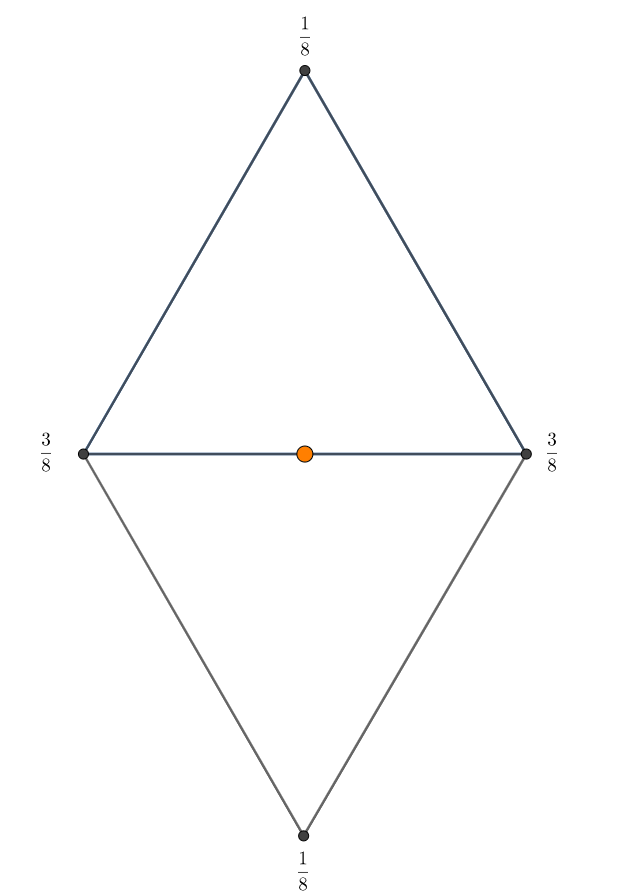

Az ábrán naracssárga pont jelöli az újonnan létrehozott csúcsot. Ennek pozícióját úgy tudjuk kiszámolni, hogy az adott félél két végpontjának pozícióját $\frac{3}{8}$ súllyal, a félél és párja lapjainak szemközti csúcsait pedig $\frac{1}{8}$ súllyal vesszük. Tehát az előbbi csúcsok pozícióját $v$-vel, az utóbbiakét $sz$-el jelölve, az új csúcs $u$ helye:

$$
  u = \frac{3}{8} (v_0 + v_1) + \frac{1}{8} (sz_0 + sz_1)
$$

Az új csúcsot tároljuk el az `NV` tömb első szabad pozícióján, melyet jelöljön $i$. Állítsuk be ezután `EM[h]` értékét $i$-re, jelölve, hogy a $h$ indexű félél az $i$ indexű csúcsot generálta. Ezt a lépést végezzük el a $h$ indexű félél $p$-vel jelölt párjára is, azaz  `EM[p]` értéke is legyen $i$. Ezzel biztosítottuk, hogy a pár felhasználásával már nem fogunk új csúcsot képezni.

#### 2. Az eredeti csúcsok elmozdítása

##### Iteráció a szomszédos csúcsokon

Az eredeti csúcsokat már az előző lépésben elhelyeztük az `NV` tömb első `V` pozícióján. Most ezek mindegyike számára elő fogunk állítani egy új pozíciót. Minden eredeti $v$ indexű csúcsra hajtsuk végre a következőt.

Legyen $e_A$ a $v$ indexű csúcsba futó félél indexe. $v$-nek szomszédja lesz az a csúcs, melybe az $e_A$ párja fut. E félél indexét jelöljük $e_B$-vel! Azt a $w$ csúcsot, melybe $e_B$ fut, a következő módon határozhatjuk meg:

~~~~
  eA = VA[v].halfEdge ; a v-be futó egyik félél indexe

  eB = HA[eA].pair; ; meghatározzuk eA párjának indexét
  
  face = FA[floor(eB / 3)] ; a lap, melyen eB fekszik
  
  index_on_face = (eB + 1) % 3 ; a lap csúcsai közül hanyadik lesz az, amelybe eB fut
  
  w = VA[face.vertices[index_on_face]] ; végül a csúcsok tömbjéből kikeressük a csúcsot
~~~~

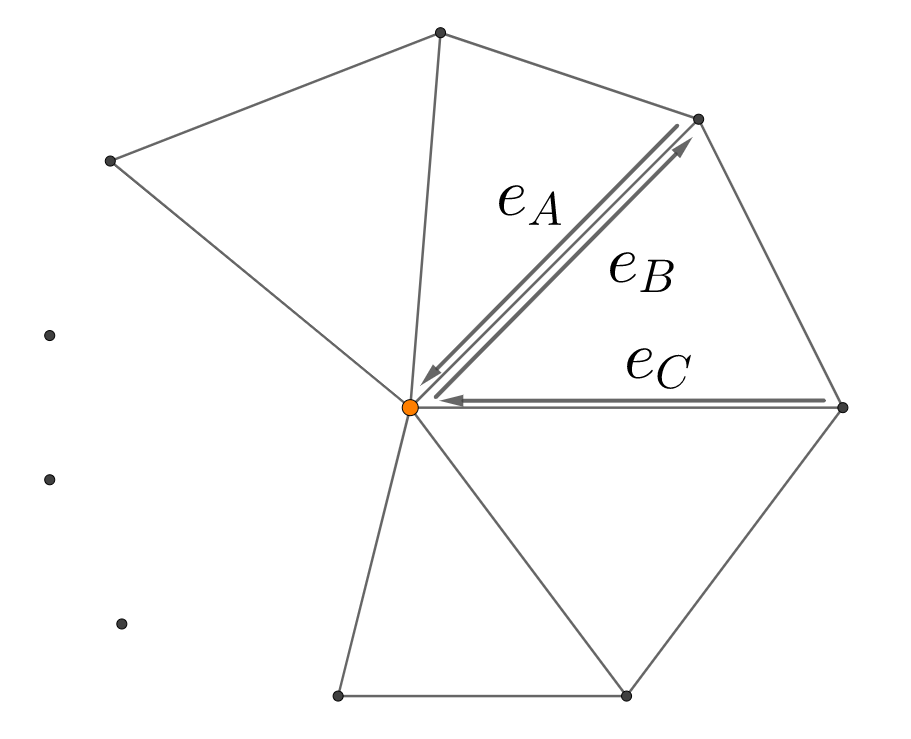

A fenti lépéssorozat a $v$ indexű csúcs egy szomszédját keresi meg. Nekünk azonban az összesre szükségünk van, tehát valamilyen módon iterálnunk kell. Ahhoz, hogy az óramutató járásának megfelelő, következő szomszédos csúcsot előállítsuk, ugranunk kell az ábrán $e_C$-vel jelölt félélre. Ha ezzel megvagyunk, már újra alkalmazhatjuk az előző algoritmust, mindaddig, amíg az aktuális $e_A$ index egyenlő nem lesz azzal a féléllel, amivel elkezdtük az iterációt (azaz `VA[v].halfEdge`). Számoljuk ki tehát $e_C$-t:

~~~~
  f = floor(eB / 3) ; azon lap indexe, melyen eB fekszik
  
  he = 3 * f ; az f indexű lapon fekvő első félél indexe
  
  eC = he + ((eB + 2) % 3) ; eC nem más, mint eB második rákövetkezője
~~~~

Ez az iteráció tehát akkor áll le, ha `eC = VA[v].halfEdge`.

##### Az új pozíció meghatározása

Tegyük fel, hogy a $v$ csúcsnak $n$ darab szomszédja van, melyeket jelöljön $v_i$. Ezen csúcsok pozícióinak az összegét jelölje $s$:

$$
  s = \sum\limits_{i = 0}^{n - 1} v_i
$$

Ezt az összeget már az iteráció közben számolhatjuk, így nem szükséges a szomszédos csúcsok eltárolása.

Az új pozíció az eredeti pozíció és a szomszédos csúcsok pozícióinak súlyozott összege lesz. Ehhez szükséges néhány további érték meghatározása:

$$
\begin{align*}
  \beta &= \bigg(\frac{3}{8} + \frac{1}{4}\cos{\bigg(\frac{2\pi}{n}\bigg)}\bigg)^2 \\
  \alpha &= \frac{1}{n} \cdot \bigg(\frac{5}{8} - \beta\bigg)
\end{align*}
$$

Ezek kiszámítását követően az új $v_{new}$ pozíció:

$$
  v_{new} = (1 - n \cdot \alpha)v + \alpha \cdot s
$$

Az új mesh csúcsait tároló `NV` tömbben az éppen módosított csúcs koordinátáit beállítjuk az előző módon kiszámolt értékekre. Ezen felül $-1$ értéket állítunk be az ebbe a csúcsba futó félél indexeként, jelezvén, hogy nem fut a csúcsba félél. 

#### 3. Lapok feldarabolása

Az eredeti mesh minden lapjából az ábrán látható módon $4$ új lapot fogunk kialakítani.

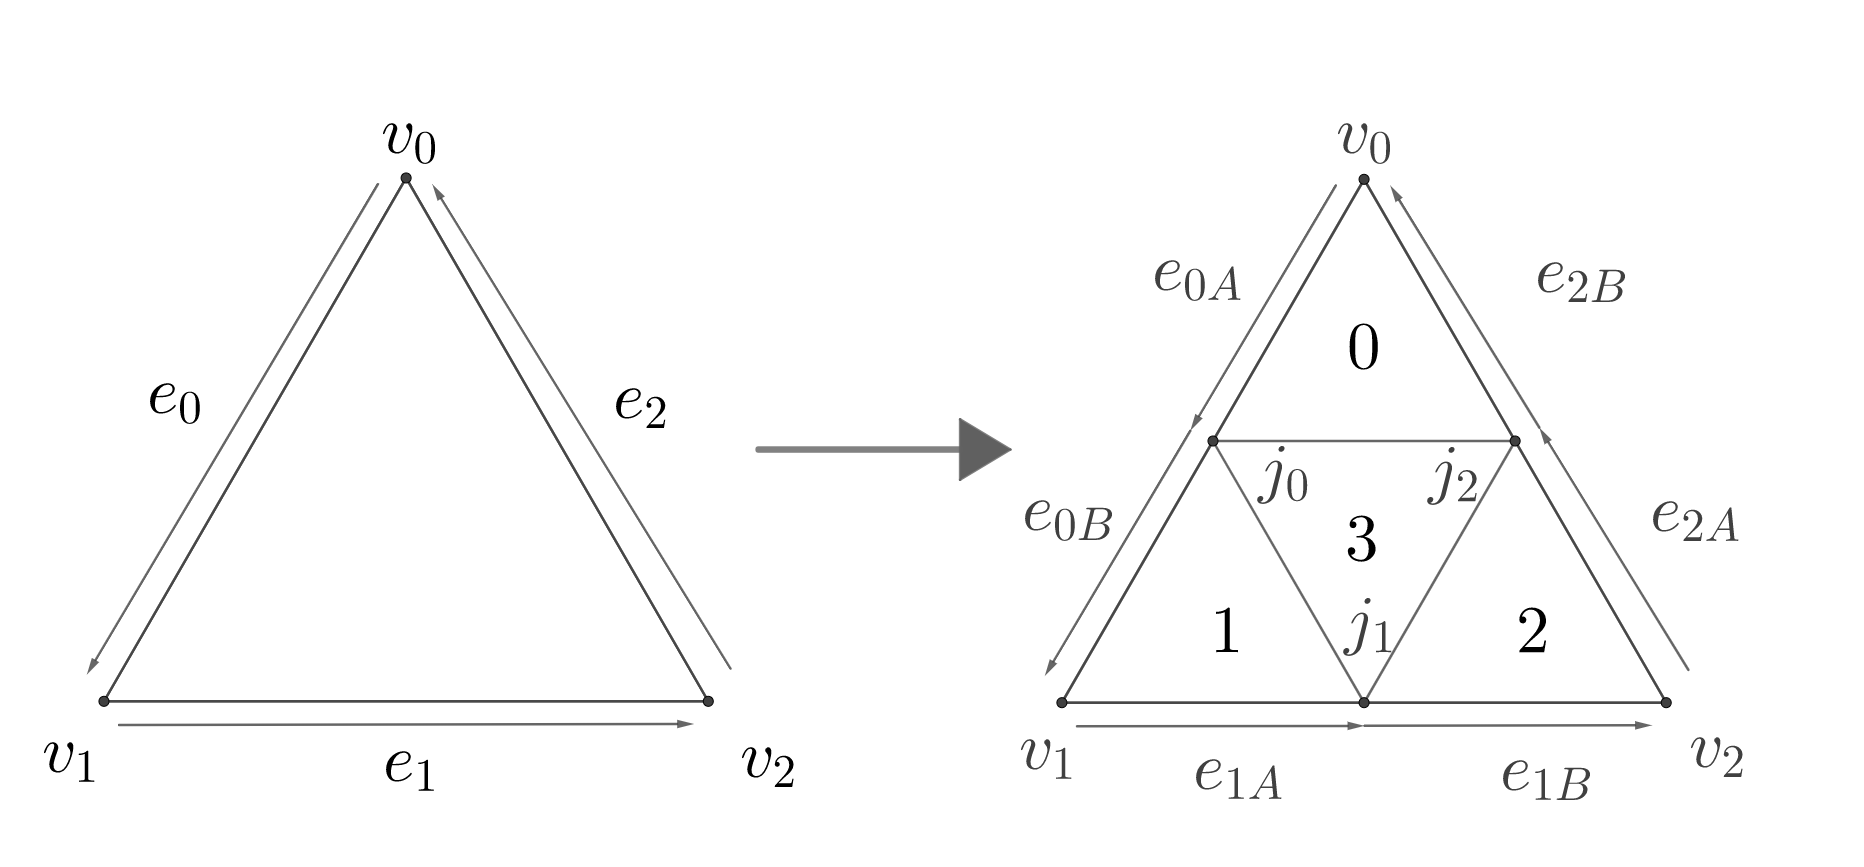

##### Memóriafoglalás

Elsőként foglaljunk le az új lapok számára egy `NF` (*new faces*) nevű tömböt, melynek elemszáma legyen $4F$. A következő lépéseket hajtsuk végre az eredeti mesh minden lapjára, az adott lap indexét $f$-fel jelölve!

##### Új csúcsok indexeinek meghatározása

Ha ismerjük egy lap indexét a régi meshben, akkor rögtön tudjuk azokat a csúcsokat is, melyek eredetileg felépítették. Viszont ahhoz, hogy az új lapokat létre tudjuk hozni, szükséges a lapot határoló félélek által generált új csúcsok indexeinek meghatározása. Ezt az `EM` tömb segítségével tudjuk megtenni. Egyszerűen mindhárom félélre lekérdezzük, hogy mely csúcsot generálta:

~~~~
  j0 = EM[3 * f]
  j1 = EM[3 * f + 1]
  j2 = EM[3 * f + 2]
~~~~

##### Új lapok létrehozása

Az eredeti (bár már elmozdított) $v_0, v_1, v_2$ és az új $j_0, j_1, j_2$ csúcsok birtokában már az ábrának megfelelően összeállíthatjuk a négy új lapot. Fontos, hogy az újonnan képzett lapok csúcsait megfelelő sorrendben adjuk meg, ahogy az is, hogy a lapokat az itt leírt sorrendben szúrjuk be a `NF` tömbbe! A megfelelő pozíciókon a következő indexeket kell beállítani:

~~~~
  NF[4 * f].vertices     = { j2, v0, j0 }
  NF[4 * f + 1].vertices = { j0, v1, j1 }
  NF[4 * f + 2].vertices = { j1, v2, j2 }
  NF[4 * f + 3].vertices = { j2, j0, j1 }
~~~~

##### Befutó félélek

Az egyik előző lépés során az egyes csúcsokba befutó éleket $-1$-re állítottuk. Az új lapok létrehozását követően már beállíthatunk olyan féléleket, melyek az új meshben befutnak a csúcsokba. Egyszerűen válasszunk egy tetszőleges, az adott csúcsba futó élt. Például, a $v_0$ csúcsba befutó egyik él a $3 \cdot 4 \cdot f$ indexű. Hasonlóan a $j_2$ csúcsba tart például a $3 \cdot 4 \cdot f + 2$ indexű félél. Ne felejtsük el mind a hat csúcsra elvégezni ezt a lépést!

Habár fordíthatunk arra figyelmet, hogy ne állítsuk be ezt az értéket ugyanazon csúcs esetén többször is, ezzel nem szükséges foglalkozni.

#### 4. Párok meghatározása

Már szinte teljesen készen vagyunk az új mesht leíró adatokkal. Az egyetlen dolog, ami még hiányzik, az a félélek párjainak beállítása. Immár szokás szerint, hozzunk létre egy új, `NE` nevű tömböt az új félélek tárolására, $3 \cdot 4 \cdot F$ elemszámmal.

A párok meghatározásához szükségünk lesz egy `nIndex` nevű függvényre, mely a következőképpen adott:

~~~~
function nIndex(ei, type)
    // a párok meghatározásához szükséges offsetek
    offsets[] = { 3, 1, 6, 4, 0, 7 }
    // az eredeti pár
    op = HA[ei].pair
    // ez nem fordulhat elő, mivel olyan meshekkel dolgozunk, ahol minden élnek van párja
    if (op == -1)
        return -1
        
    bp = 12 * floor(op /3)
    
    return bp + offsets[2 * (op % 3) + type]
~~~~

Ez a némileg ezoterikus függvény fog segíteni megtalálni, hogy az új lapok létrejöttével melyik félélnek melyik másik lesz a párja. Minden eredeti $f$ indexű lapra hajtsuk végre a következő lépéseket:

  1. Legyen $b = 12f$ egy bázisérték! $b$-től kezdve egészen $b + 11$-ig fognak elhelyezkedni az `NE` tömbben azok a félélek, melyek az $f$ lapból kialakított négy lap valamelyikére esnek. 
  1. Állítsuk be a párokat az `NE` tömbben az `nIndex` függvény segítségével. Érdemes a függvény paramétereit összehasonlítani az előző, a lapok felosztása során látott ábrával. Az `(f * 3) + x` kifejezésben `x` mondja meg, hogy az $e_x$ indexű csúcsról van szó, a második paraméter pedig azt, hogy $A$ ($ = 0$)vagy $B$ ($ = 1$) típusú az adott félél.
  
~~~~
    NE[b].pair = nIndex((f * 3) + 2, 1)
    NE[b + 1].pair = nIndex((f * 3), 0)
    NE[b + 2].pair = b + 9

    NE[b + 3].pair = nIndex((f * 3), 1)
    NE[b + 4].pair = nIndex((f * 3) + 1, 0)
    NE[b + 5].pair = b + 10

    NE[b + 6].pair = nIndex((f * 3) + 1, 1)
    NE[b + 7].pair = nIndex((f * 3) + 2, 0)
    NE[b + 8].pair = b + 11

    NE[b + 9].pair = b + 2
    NE[b + 10].pair = b + 5
    NE[b + 11].pair = b + 8
~~~~


#### 5. Befejezés

A finomítás végrehajtásának utolsó lépése, hogy a mesht tároló adatszerkezetünkben a `VA`, `FA` és `HA` tömböket kicseréljük az `NV`, `NF` és `NE` tömbökre, azaz a régi mesht kicseréljük az új, simább változatra. A következő iterációban már ezt fogjuk tovább finomítani.

## Demonstráció

A demonstráció a séma működését mutatja be egy kockán. A kamerát a már ismert módon kezelhetjük (leírás [itt](http://nbviewer.jupyter.org/github/kompgraf/course-material/blob/master/notebooks/06-bezier-felulet/06-bezier-felulet.ipynb#Demonstráció])). Újabb finomítást az <kbd>ENTER</kbd> leütésével hajthatunk végre.

In [3]:
addScript('js/loop-subdivision', 'loop-subdivision')

## Források

A kiírás a következő cikkben leírt algoritmus alapján készült:

 * Chris Lomont (2007). *High Performance Subdivision Surfaces* https://www.lomont.org/Math/Papers/2008/Lomont_Subdivision_2008.pdf

In [2]:
def styling():
    styles = open("../../styles/custom.html", "r").read()
    return HTML(styles)
styling()
